# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [2]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [4]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
filepath=Path('Data/neighborhoods_coordinates.csv')
data=pd.read_csv(filepath,index_col='Neighborhood')


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [5]:
units_per_year=sfo_data.groupby(sfo_data.index).mean()
peryearsold=units_per_year['housing_units']
avghousingdf=units_per_year.drop(columns='housing_units')
year_neighborhood=sfo_data.groupby(['year','neighborhood']).mean()
yearly_neighborhood=year_neighborhood.drop(columns='housing_units')
top10owned=yearly_neighborhood.groupby('neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False).head(10).drop(columns='gross_rent')
top10yearly = sfo_data[sfo_data["neighborhood"].isin(top10owned.index)].drop(columns='housing_units')
top10yearlyfull = sfo_data[sfo_data["neighborhood"].isin(top10owned.index)]
top=top10yearlyfull.groupby('neighborhood').mean().reset_index()
sunburstdata=top10yearly.reset_index()
plotdata=sfo_data.groupby(['neighborhood']).mean()
plotdata=pd.concat([plotdata,data],axis='columns',join='outer')
plotdata.reset_index(inplace=True)
plotdata=plotdata.dropna()


In [24]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    plot1=peryearsold.hvplot.bar(ylim=(370000,385000)
                    , title='Housing Units in San Fransisco from 10\'-16\''
                    #, ylabel= "Units Sold"
                    #, xlabel='Year'
                    , rot=0
                    , grid=False
                    , figsize=(5,5)
                    )
    return plot1


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    rentplot=avghousingdf['gross_rent'].hvplot.line(
                      title='Monthly Gross Rent Average'
                    #, ylabel='Price per Month'
                    #, xlabel='Year'
                    , rot=0
                    , grid=True
                    , lw=2
                    , figsize=(5,5)
                    , color='r'
                    , xlim=(2010,2016)
            )
    return rentplot 


def average_sales_price():
    """Average Sales Price Per Year."""
    saleplot=avghousingdf['sale_price_sqr_foot'].hvplot.line(
                     title='Yearly Price per Sqft Average'
                    #, ylabel='Price per SqFt'
                    #, xlabel='Year'
                    , rot=0
                    , lw=2
                    , grid=True
                    , figsize=(5,5)
                    , xlim=(2010,2016)
                    )
    return saleplot


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    prorent=yearly_neighborhood.hvplot.line(
                      y=['gross_rent','sale_price_sqr_foot']
                    , x='year'
                    , subplots=False
                    # by='year'
                    , groupby=['neighborhood']
                    , ylim=(0,5000)
                    , xlim=('2010','2017')
                    , dynamic=False
                    #, height=500
                    , hover_cols='one'
                )
    prosale=yearly_neighborhood.hvplot.line(
                     y='sale_price_sqr_foot'
                    , x='year'
                    , subplots=False
                    # by='year'
                    , groupby=['neighborhood']
                    , ylim=(0,2500)
                    , dynamic=False
                    #, height=500
                    , hover_cols='one'
                )
    return (prorent)


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    top10owned=yearly_neighborhood.groupby('neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False).head(10).drop(columns='gross_rent')
    top10plot=top10owned.hvplot(
                      kind='bar'
                    , color='blue'
                    , rot=90
                    , title='Top 10 Expensive Neighborhoods in SFO'
                    , ylabel='Avg. Sale Price Per Sqft'
                    , x='neighborhood'
                    , ylim=(600,900)
                )
    return top10plot


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    top10yearplot=top10yearly.hvplot(
                      kind='bar'
                    , color='blue'
                    , rot=90
                    , title='Top 10 Expensive Neighborhoods in SFO'
                    , ylabel='Avg Price SQFT/ Monthly Rent'
                    , x='year'
                    , y=(['sale_price_sqr_foot','gross_rent'])
                    , groupby='neighborhood'
                    , dynamic=False
                )
    return top10yearplot
 

        
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    plelcordplot=px.parallel_coordinates(top,color=top.index, width = 1000, height = 500)
    return plelcordplot


def parallel_categories():
    """Parallel Categories Plot."""
    
    plelcategplot=px.parallel_categories(top,color='sale_price_sqr_foot',)
    return plelcategplot


def neighborhood_map():
    """Neighborhood Map."""
    map_box = px.scatter_mapbox(
                        plotdata,
                        lat="Lat",
                        lon="Lon",
                        size="gross_rent",
                        color="index",
                        zoom=10
                    )
    map_box.update_layout(
                        mapbox_style="streets"
                        )
    return map_box
    


def sunburst():
    """Sunburst Plot."""
    
    sunbursplot=px.sunburst(sunburstdata,path=['year','neighborhood'],values='sale_price_sqr_foot',color='gross_rent',color_continuous_scale='RdBu')
    return sunbursplot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [25]:
# Create a Title for the Dashboard
# YOUR CODE HERE!


# Create a tab layout for the dashboard
welcome_column=pn.Column(
    "## MAp of San Fansisco Housing Market",
    neighborhood_map()
    )
yearlymarketcolumn=pn.Column(
    "## Side x Side Analysis of Yearly Averages",
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price(),
)
neighbhoodcolumn=pn.Column(
    "## Top Ten Expensive Homes in SF Area",
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods(),
    most_expensive_neighborhoods_rent_sales()
)
parallelplotcolumn=pn.Column(
    "## Parelle Categories and Plots",
    parallel_coordinates(),
    parallel_categories()
)
sunburstcolumn=pn.Column(
    "## Sunburst Data",
    sunburst()
)
# Create the dashboard
sfo_housing_dashboard=pn.Tabs(
     ('Welcome',welcome_column)
    ,('Yearly Market Analysis',yearlymarketcolumn)
    ,('Neighborhood Analytics',neighbhoodcolumn)
    ,('Parellel Plot Analysis',parallelplotcolumn)
    ,('Sunburst Plot Analysis',sunburstcolumn)
)

## Serve the Panel Dashboard

In [27]:
# Serve the# dashboard
sfo_housing_dashboard.show()

Launching server at http://localhost:62773


# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

<AxesSubplot:title={'center':"Housing Units in San Fransisco from 10'-16'"}, xlabel='year'>

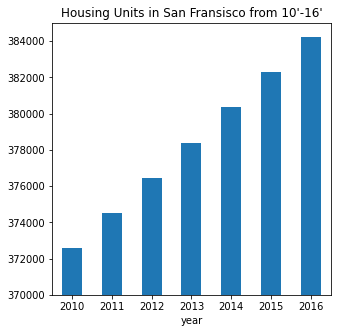

In [9]:
housing_units_per_year()

<AxesSubplot:title={'center':'Monthly Gross Rent Average'}, xlabel='year'>

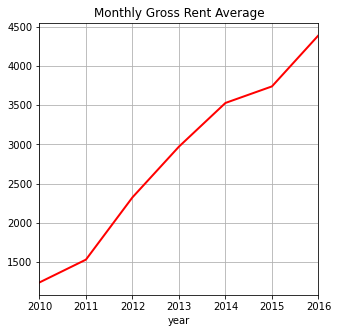

In [10]:
 average_gross_rent()

<AxesSubplot:title={'center':'Yearly Price per Sqft Average'}, xlabel='year'>

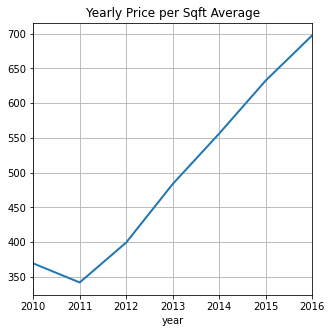

In [11]:
 average_sales_price()

In [12]:
average_price_by_neighborhood()

:HoloMap   [neighborhood]
   :NdOverlay   [Variable]
      :Curve   [year]   (value)

In [13]:
 top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [14]:
 most_expensive_neighborhoods_rent_sales()

:HoloMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [15]:
neighborhood_map().show()

In [16]:
 parallel_categories()

In [17]:
 parallel_coordinates()

In [18]:
 sunburst()